In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lightkurve.lightcurve import LightCurve as LC
from bls import BLS
from matplotlib import gridspec
import eleanor
from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
from IPython.display import YouTubeVideo

print(eleanor.__version__)

0.1.8rc1


# The Goal

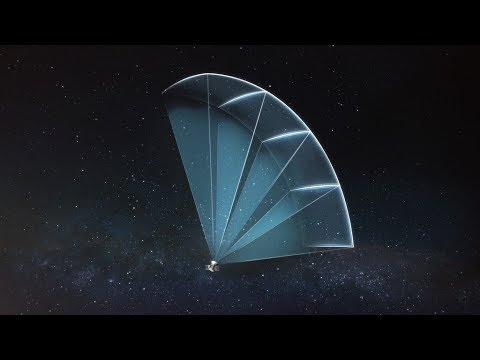

In [2]:
id = 'evHF_mnIdj4'
YouTubeVideo(id=id,width=900,height=500)

We want to create light curves for stars (or other objects!) found within the TESS Full-Frame Images (FFIs). Grabbing pixels from the FFI and doing a bit of photometry shouldn't be a problem, right? The big issue is that the FFIs are big (~35Mb) and there are a lot of them for each sector (~21,000) and it's safe to assume most people don't have access to that kind of computing space.

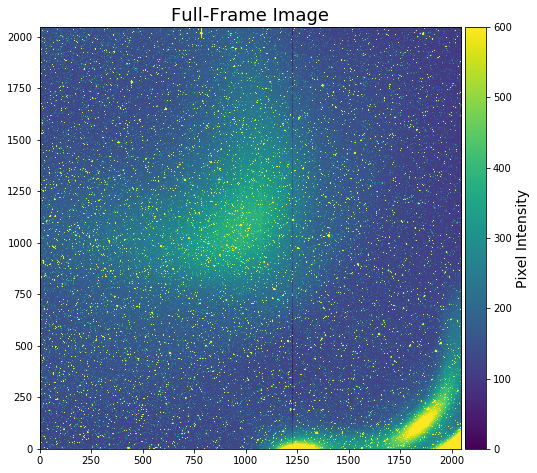

In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

data = np.load('ffi_2d.npy')

plt.figure(figsize=(8,8))
ax = plt.gca()
im = ax.imshow(data, origin='lower', vmin=0, vmax=600)
plt.title('Full-Frame Image', fontsize=18)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax).set_label(label='Pixel Intensity', fontsize=14)
plt.show()

# Let's start making light curves!

![SegmentLocal](eleanor.gif "ellie")

# Pass in a TIC ID $\rightarrow$ Get a Light Curve!

As a simple first example, we will use $\texttt{eleanor}$ to create a target pixel file (TPF) and a light curve for a given TESS Input Catalog (TIC) target.

We will load in the data for TIC 234503282. Calling $\texttt{eleanor.Source()}$ will assign a $\textit{Gaia}$ ID, coordinates, TESS magnitude, sector, camera, CCD, and associated postcard.

In [4]:
star = eleanor.Source(tic=234503282, sector=1)

Here is just some of the information we receive when we call $\texttt{eleanor.Source()}$.

In [5]:
print('TIC ID: ',star.tic)
print('Coordinates: ', star.coords)
print('Camera, Chip Location: ', star.camera, ',', star.chip)
print('TESS mag: ', star.tess_mag)

TIC ID:  234503282
Coordinates:  [11.595497, -63.473076]
Camera, Chip Location:  3 , 1
TESS mag:  10.912


As mentioned previously, a postcard is assigned when calling $\texttt{eleanor.Source()}$, but what exactly is a postcard? A postcard is a 148 $\times$ 104 pixel cutout of the FFIs that are time-stacked and background subtracted. For the postcard background, we subtract a constant from the frame using $\texttt{photutils.MMMBackground()}$. The background at each cadence is passed through with the postcard object. This is the postcard that is assigned to our source TIC234503282.

Now that we have our Source information, we simply call the $\texttt{eleanor.TargetData()}$ function, which will extracted a TPF, perform aperture photometry with an automatically optimized aperture choice, and complete some simple systematics corrections.

For first time users, or users looking at this part of the TESS FOV for the first time, a file will download. Don't be alarmed! We promise it's not a virus. The downloading file is the postcard that we just discussed.

If you call do_psf=True (which enables you to complete a simple point-spred function model), a loading bar will appear to let you know which cadence the model is on and when. If you do not call do_psf, no loading bar will appear.

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
100%|██████████| 1282/1282 [00:38<00:00, 33.08it/s]


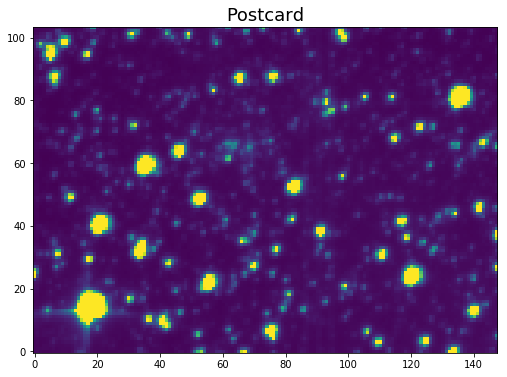

In [6]:
data = eleanor.TargetData(star, height=15, width=15, do_psf=True, do_pca=True)

plt.figure(figsize=(14,6))
plt.imshow(data.post_obj.flux[:,:,0], origin='lower', vmax=200)
plt.title('Postcard', fontsize=18)
plt.show()

In [7]:
star.postcard

'hlsp_eleanor_tess_ffi_postcard-s0001-3-1-cal-1098-0970.fits'

Yay! We have our light curve object! First thing's first: let's take a peak at the pixels themselves and the "best" aperture automatically selected by $\texttt{eleanor}$. If all goes as planned, your target should be in or very close to the center of the TPF frame.

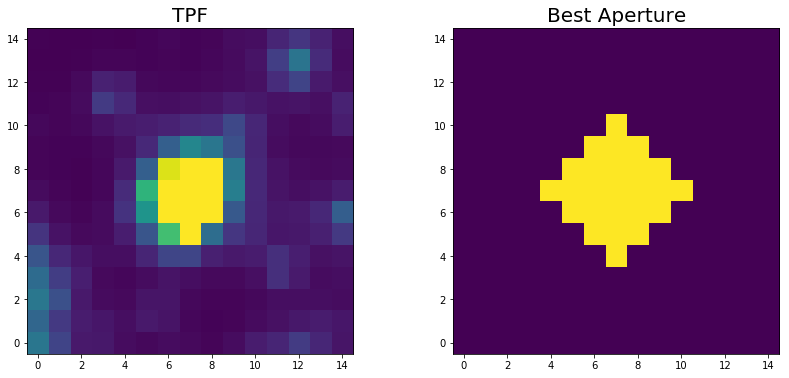

In [8]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(14,6))
ax1.imshow(data.tpf[0], origin='lower', vmax=200)
ax1.set_title('TPF', fontsize=20)
ax2.imshow(data.aperture, origin='lower')
ax2.set_title('Best Aperture', fontsize=20)
plt.show()

At first glance, this aperture may be a little big... But we'll deal with that in a little bit. First, let's see what the background looks like. There are two steps to the background subtraction: on the postcard level and on the TPF level. We can check how much background was subtracted by calling:

In [9]:
data.bkg_type

'PC_LEVEL'

"PC_LEVEL" means Postcard Level, so no additional background was subtracted at the TPF level. Let's take a look at what the background actually looks like:

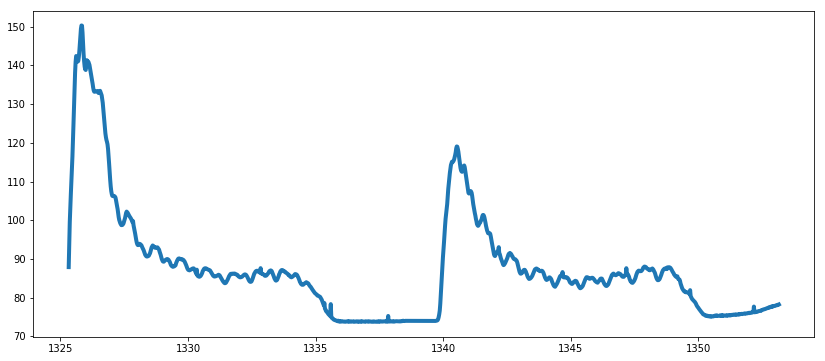

In [10]:
plt.figure(figsize=(14,6))
plt.plot(data.time, data.flux_bkg, linewidth=4)
plt.show()

This is pretty close to what we expect for the background. What's causing this structure? Earth-shine! In addition to background, we also create Quality Flags for the user. These will alert the user of spacecraft issues such as thruster fires, where the data at that time might not be good/useful. We can plot the Quality Flags:

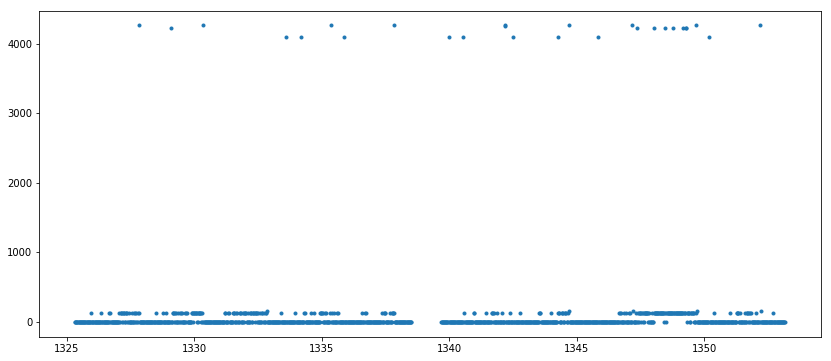

In [11]:
plt.figure(figsize=(14,6))
plt.plot(data.time, data.quality, '.', linewidth=4)
plt.show()

Any cadence where the Quality Flag != 0 is potentially not a good one. I think it's time to plot our first light curve! We're only going to plot the cadences with good quality flags. We provide FOUR different light curve options:
    1. Raw Flux -- Just the aperture photometry.
    2. Corrected Flux -- Minimal correction pointing variations, background, and removal of long term trends.
    3. PCA Flux -- Principal Component Flux is used to help remove any common systematics seen in light curves on 
                   the same chip.
    4. PSF Flux -- the Point-Spread Function modeled flux.

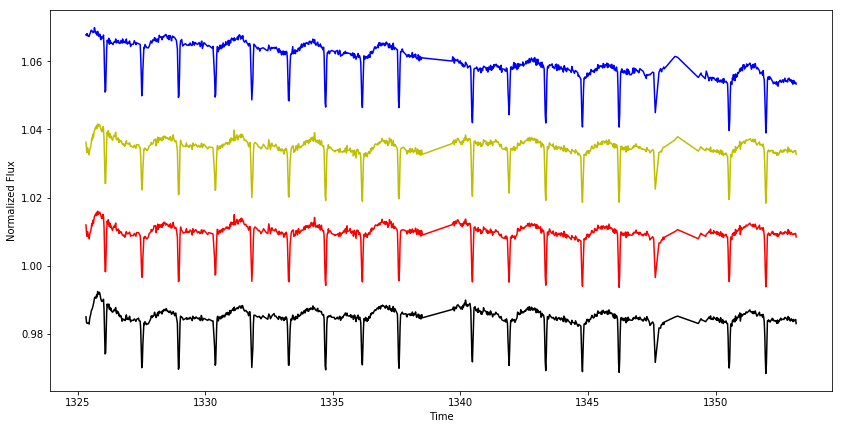

In [12]:
# We provide quality flags! You should use them
q = data.quality == 0

plt.figure(figsize=(14,7))
plt.plot(data.time[q], data.raw_flux[q]/np.median(data.raw_flux[q])-0.015, 'k')
plt.plot(data.time[q], data.corr_flux[q]/np.median(data.corr_flux[q]) + 0.01, 'r')
plt.plot(data.time[q], data.pca_flux[q]/np.median(data.pca_flux[q]) + 0.035, 'y')
plt.plot(data.time[q], data.psf_flux[q]/np.median(data.psf_flux[q]) + 0.06, 'b')

plt.ylabel('Normalized Flux')
plt.xlabel('Time')
plt.show()

Yay light curves! Yay a signal! What could it be?? First, we should try creating a light curve with a smaller aperture, to make sure there isn't a background source causing this signal. TESS's pixels are large, so this is a good test to do. LUCKILY! Every $\texttt{eleanor.TargetData()}$ object comes equipt with all of the apertures we tested and all of the raw and corrected fluxes for these additional apertures.

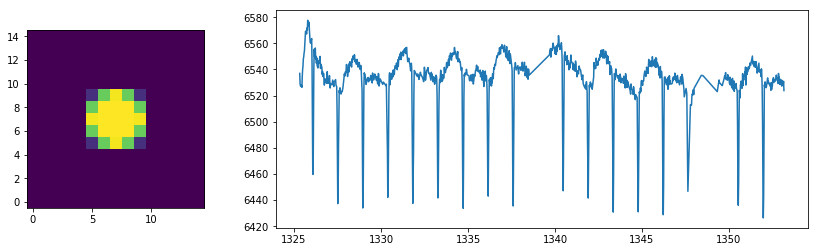

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(14,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3], height_ratios=[2]) 
ax0 = plt.subplot(gs[0])
ax0.imshow(data.all_apertures[13], origin='lower')
ax1 = plt.subplot(gs[1])
ax1.plot(data.time[q], data.all_raw_lc[13][q])
plt.show()

If the 21 apertures $\texttt{eleanor.TargetData()}$ provides you with isn't enough, or you want to try a different shape or weighting scheme, you can create your own 2D array of the same shape as the TPF and pass that in as an aperture.

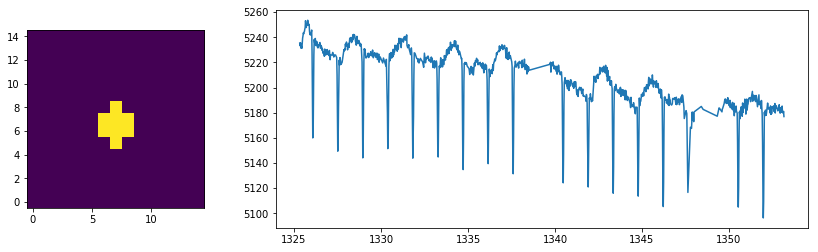

In [14]:
mask = np.zeros(np.shape(data.tpf[0]))
mask[5,7] = 1
mask[6:8,6:9] = 1
mask[8,7] = 1

data.get_lightcurve(aperture=mask)

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(14,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3], height_ratios=[2]) 
ax0 = plt.subplot(gs[0])
ax0.imshow(mask, origin='lower')
ax1 = plt.subplot(gs[1])
ax1.plot(data.time[q], data.raw_flux[q])
plt.show()

Our potentially new planet candidate transit signal is still there! This is a promising sign. 

Before we move on to convincing ourselves that this transit signal may be real, what else can we do within $\texttt{eleanor.TargetData()}$?

We can run PCA with the flux from this new mask and choose the number of components we want to use. The default number of modes within $\texttt{eleanor}$ is 8, but we have 16 components created.

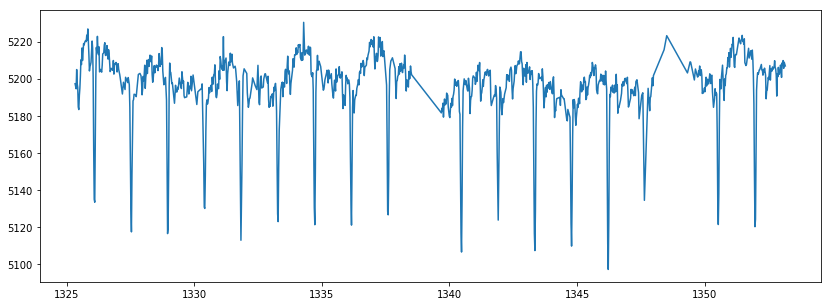

In [15]:
data.pca(flux=data.corr_flux, modes=10)
plt.figure(figsize=(14,5))
plt.plot(data.time[q], data.pca_flux[q])
plt.show()

In [16]:
data.save()

# Pass in Coordinates $\rightarrow$ Get Light Curve for a Target Observed in Multiple Sectors

Great! Now we know how to create a light curve using $\texttt{eleanor.Source()}$ and $\texttt{eleanor.TargetData()}$ with a TIC ID. Now, let's do it all over again, but this time we'll highlight two additional features:
    1. Pass in coordinates to get a light curve.
    2. Create a light curve for a source observed in multiple sectors (in this case, we only have Sectors 1 
       and 2 ready for use).
       
First, we have to assign our coordinates with a unit. This allows users to pass in coordinates in degrees or hourangle. Then, instead of calling $\texttt{eleanor.Source()}$ as we did last time, we'll call $\texttt{eleanor.multi_sectors()}$, which additionally requires a list of sectors you want. If we call $\texttt{eleanor.Source()}$, it will return the light curve for the most recent sector the target was observed in.

In [17]:
ra  = Angle(11.595497, u.deg)
dec = Angle(-63.473076,u.deg)

stars = eleanor.multi_sectors(coords=SkyCoord(ra,dec), sectors=[1,2])

$\texttt{eleanor.multi_sectors()}$ returns a list of $\texttt{eleanor.Source()}$ objects! We can then pass these into $\texttt{eleanor.TargetData()}$ individually to create light curves for each sector.

In [18]:
stars

In [19]:
data0 = eleanor.TargetData(stars[0], height=15, width=15, bkg_size=31, do_psf=True, do_pca=True)
data1 = eleanor.TargetData(stars[1], height=15, width=15, bkg_size=31, do_psf=True, do_pca=True)

100%|██████████| 1282/1282 [00:32<00:00, 39.85it/s]


100%|██████████| 1245/1245 [00:33<00:00, 36.82it/s]


And let's plot the light curve for this source from both sectors...

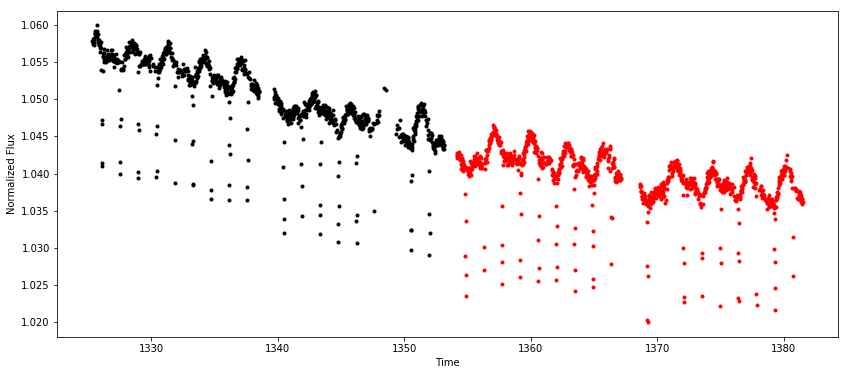

In [20]:
q0 = data0.quality == 0
q1 = data1.quality == 0

plt.figure(figsize=(14,6))
plt.plot(data0.time[q0], data0.psf_flux[q0]/np.median(data0.psf_flux[q0]) + 0.05, 'k.')
plt.plot(data1.time[q1], data1.psf_flux[q1]/np.median(data1.psf_flux[q1]) + 0.04, 'r.')

plt.ylabel('Normalized Flux')
plt.xlabel('Time')
plt.show()

Oh my! Another new potential planet candidate signal! Just kidding -- This is the same source as we used in the first part :) We just used the coordinates rather than the TIC ID to create the light curve. I leave the rest of the steps we looked at before as an exercise to the user.

In [21]:
data.save(output_fn='test.fits', directory='.')

# Let's fit it!

We've all been super curious as to what this signal could be. Let's do a bit of initial vetting! The first trick to try is a Box-Least Squares analysis using $\texttt{bls.py}$, an open-source packge created by Dan Foreman-Mackey. Planet transits, unlike eclipsing binaries, are quite boxy in shape. We can fit a box to a phase-folded light curve and see if the data matches well. The rest of this notebook will go over how to call $\texttt{bls.py}$ and its outputs.

We'll be calling $\texttt{bls.py}$ a few times so, as is good practice, let's make this a function.

In [24]:
def bls_fitting(t, lc):  
    # Make a lightkurve LightCurve object. This will allow us to easily flatten our light curve.
    lk = LC(time=t, flux=lc)
    lc_filt = lk.flatten(window_length=51).flux


    # Create BLS Object:
    #     BLS will fit an array of transit duration times.
    #     You also can pass in a minimum and maximum period, given in days.
    durations = np.linspace(0.05, 0.2, 10)
    model     = BLS(t, lc_filt)
    results   = model.autopower(durations, frequency_factor=5.0,
                                maximum_period=15)
    
    # Find the period and duration from the maximum power peak
    period = results.period[np.argmax(results.power)]
    dur = results.duration[np.argmax(results.power)]
    
    # Find the transit time
    t0 = results.transit_time[np.argmax(results.power)]
    
    # Fold the light curve over the transit time
    t_fold = (t - t0 + 0.5*period) % period - 0.5*period

    
    # EVERYTHING BEYOND HERE IN THE FUNCTION IS FOR PLOTTING PURPOSES
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=1,nrows=3, figsize=(16,11))

    ax2.axvline(period, color='goldenrod', alpha=0.4, lw=5)
    for n in range(2, 10):
        ax2.axvline(n*period, alpha=0.4, lw=1, linestyle="dashed")
        ax2.axvline(period / n, alpha=0.4, lw=1, linestyle="dashed")

    ax2.plot(results.period, results.power, "k", lw=1)

    ax2.set_xlim(np.min(results.period), np.max(results.period))
    ax2.set_xlabel("period [days]")
    ax2.set_ylabel("log likelihood")

    ax1.plot(t, lc_filt, '.', color="midnightblue")

    ax3.plot(t_fold, lc_filt, 'k.')
    ax3.set_xlim(-4*dur, 4*dur)
    plt.show()

Let's pass in a time and a light curve into our $\texttt{bls_fitting}$ function and see what plots.

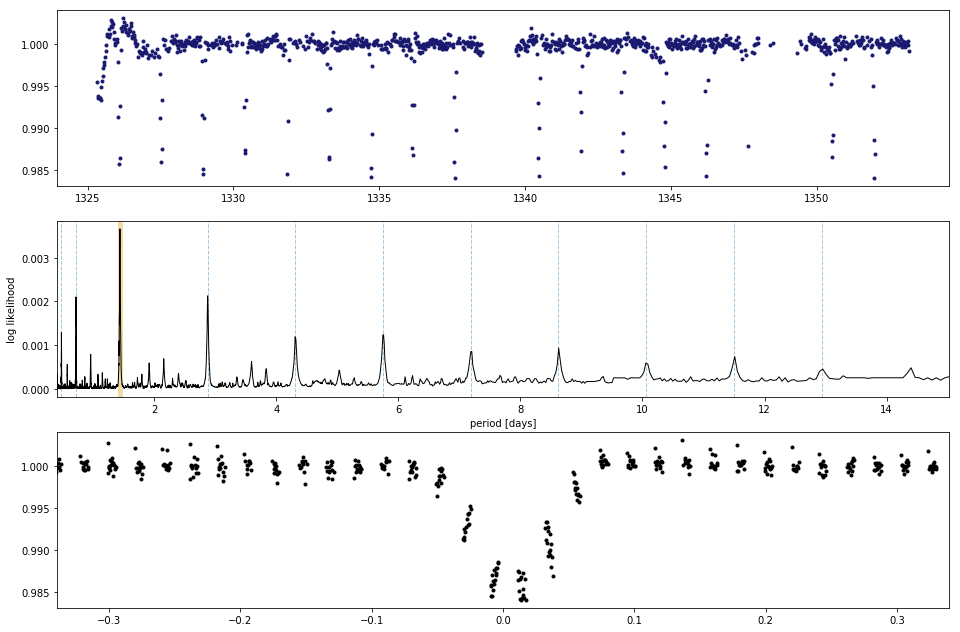

In [25]:
bls_fitting(data0.time[q0], data0.raw_flux[q0])

The first subplot shows our light curve and the deep potential transits we know and love. The second subplot shows the periodogram, where the x-axis is the period in days and the y-axis is the log likelihood. Highlighted in yellow is the peak of the function and the dashed blue lines represent harmonics of the transit. We see that all of the lines line up nicely with peaks in the function. The third subplot is our phase-folded light curve. It looks really good!

We can do the same analysis with the light curves from both sectors as well.

# Now you try!

TIC 139771134

Gaia 6582115549524788480 (Hint: You do not need to look up the associated TIC ID or coordinates for this source.)

RA, Dec = 04:35:54.594, -66.133666

TIC 260304296

RA, Dec = 113.593357, -64.936218

Guiding questions:

    1. Which have been observed in both Sectors 1 & 2?
    2. Which have potential new planet candidate transits?
    3. Which option of flux gives the clearest signal of a transit?

Currently, only Sectors 1 and 2 are available with $\texttt{eleanor}$ and we're working to get all available sectors working soon!